<a href="https://colab.research.google.com/github/DkMaria/Fake-News-Detection/blob/main/imbalanced_word2vec_12_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
# Download following if not downloaded in local machine
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import imblearn
from collections import Counter

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

FALSE:                                                 headline  ... label
0                           Who Stripped Jessica Rabbit  ...     1
1            Translation of Turkish Airline Regulations  ...     1
2     The health care law a ""job killer""? The evid...  ...     1
3     FALSE: Trump Supporters Misspelled His Name wi...  ...     1
4                      Tom Daschle Pledge of Allegiance  ...     1
...                                                 ...  ...   ...
9995  Rauner's Chicago schools ""bailout"" claim roo...  ...     1
9996  Did President Trump Sign an Executive Order Na...  ...     1
9997                                One Pound of Mofeen  ...     1
9998  No, Trump didn't say illegal immigration has b...  ...     1
9999   Is This a Poster for a New ‚ÄòTwilight‚Äô Movie?  ...     1

[10000 rows x 5 columns]


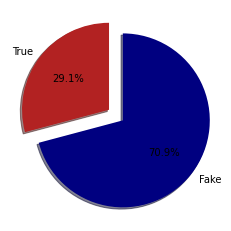

In [ ]:
# read csv files which contains all TRUE and all FALSE claims
true = pd.read_csv('/content/drive/MyDrive/true28.csv', delimiter=",")
df_true = pd.DataFrame(true, columns=['headline', 'text', 'keywords', 'ratingName'])
df_true['label'] = 0
# print('TRUE: ', df_true)
# print(len(df_true)) # 4113


false = pd.read_csv('/content/drive/MyDrive/false05.csv', delimiter=",", encoding='mac_roman')
df_false = pd.DataFrame(false, columns=['headline', 'text', 'keywords', 'ratingName'])
df_false['label'] = 1
print('FALSE: ', df_false)
# print(len(df_false)) #10000

data = pd.concat([df_true, df_false])
labels = data['label']
# print(data) # 14113
# print(data['label'].value_counts())
# 1: 10000
# 0: 4113

# check if the dataset is well balanced
label_size = [4113, 10000]
plt.pie(label_size, explode=[0.1, 0.1], colors=['firebrick', 'navy'], startangle=90, shadow=True,
        labels=['True', 'Fake'], autopct='%1.1f%%')
plt.show()

# shuffle the dataset
data = data.sample(frac=1)
# print(data.head(20))

In [ ]:
label = data['label']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14113 entries, 9097 to 3175
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   headline    14113 non-null  object
 1   text        14113 non-null  object
 2   keywords    14113 non-null  object
 3   ratingName  14113 non-null  bool  
 4   label       14113 non-null  int64 
dtypes: bool(1), int64(1), object(3)
memory usage: 565.1+ KB


In [ ]:
# class count
true_count, false_count = data['label'].value_counts()
# Separate class
true = data[data['label'] == 0] #true claims
false = data[data['label'] == 1]# print the shape of the class #false claims
print('true 0:', true.shape)
print('false 1:', false.shape)

true 0: (4113, 5)
false 1: (10000, 5)


total class of 1 and 0: 1    4113
0    4113
Name: label, dtype: int64


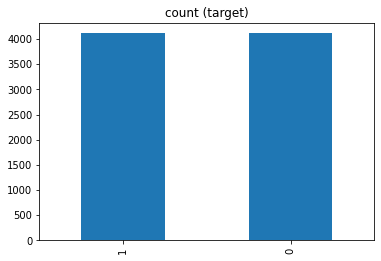

In [ ]:
'''Undersampling can be defined as removing some observations of the majority class. This is done until the majority and 
minority class is balanced out'''
false_under = false.sample(false_count)
#print(class_1_under)

data = pd.concat([false_under, true], axis=0)

print("total class of 1 and 0:",data['label'].value_counts())# plot the count after under-sampeling
data['label'].value_counts().plot(kind='bar', title='count (target)')

In [ ]:
'''Oversampling can be defined as adding more copies to the minority class. Oversampling can be a good choice when 
   you don’t have a ton of data to work with. A con to consider when undersampling is that it can cause overfitting 
   and poor generalization to your test set'''
'''true_over = true.sample(true_count, replace=True)

data = pd.concat([true_over, false], axis=0)

print("total class of 1 and 0:",data['label'].value_counts())# plot the count after under-sampeling
data['label'].value_counts().plot(kind='bar', title='count (target)')'''

'true_over = true.sample(true_count, replace=True)\n\ndata = pd.concat([true_over, false], axis=0)\n\nprint("total class of 1 and 0:",data[\'label\'].value_counts())# plot the count after under-sampeling\ndata[\'label\'].value_counts().plot(kind=\'bar\', title=\'count (target)\')'

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8226 entries, 5509 to 3175
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   headline    8226 non-null   object
 1   text        8226 non-null   object
 2   keywords    8226 non-null   object
 3   ratingName  8226 non-null   bool  
 4   label       8226 non-null   int64 
dtypes: bool(1), int64(1), object(3)
memory usage: 329.4+ KB


In [ ]:
target = data['label']

In [ ]:
y = data["text"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del data

In [ ]:
len(X)

Word2Vec implementation
Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

Word embedding is the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.


In [ ]:
#create and check our own Word2Vec model with gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
#vocab size
len(w2v_model.wv.vocab)

14754

In [ ]:
#see a sample vector for random word, lets say health
w2v_model["health"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-0.33335397,  0.03902758, -0.6460469 , -0.44018677, -0.22740674,
        0.06849106,  0.60533786,  0.00134206, -0.23079404, -0.08126872,
       -0.42225954,  0.23983958, -0.19533892,  0.36231148, -0.23459122,
       -0.312573  , -0.15515046, -0.24280843,  0.013661  ,  0.37562025,
        0.05169209, -0.42787465, -0.16991161,  0.28508008, -0.21537372,
        0.24171318,  0.12868705, -0.03319954,  0.04874913, -0.7380879 ,
        0.09117217,  0.52294534,  0.14916714, -0.10097983,  0.08430981,
        0.29673496, -0.09322014,  0.00121719,  0.2875889 , -0.16156532,
        0.62578446, -0.6580366 , -0.11199751,  0.02593839,  0.04568008,
       -0.19350226, -0.76453215,  0.1697544 ,  0.13049729,  0.27994826,
        0.13943397,  0.1761553 , -0.04204299,  0.7487399 ,  0.06765334,
        0.02081623,  0.5520353 , -0.23482962, -0.17509715,  0.6214328 ,
        0.67082196, -0.4237635 , -0.28527847,  0.68744516,  0.13894665,
       -0.3268612 ,  0.7594661 ,  0.45862907, -0.07251662,  0.01

In [ ]:
#Feeding US Presidents
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])

[('president', 0.9992349743843079),
 ('says', 0.9989332556724548),
 ('said', 0.9988917112350464),
 ('campaign', 0.9988412261009216),
 ('bush', 0.9988091588020325),
 ('former', 0.9987893104553223),
 ('wants', 0.998529851436615),
 ('first', 0.9984986782073975),
 ('office', 0.9984872937202454),
 ('would', 0.9984787702560425)]

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [ ]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[279, 436, 744, 1071, 4186, 3436, 6, 704, 2537, 127]

In [ ]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break  

says -> 1
president -> 2
shows -> 3
trump -> 4
obama -> 5
percent -> 6
state -> 7
äôs -> 8
people -> 9
photograph -> 10


We can pass numerical representation of words into neural network.

We can use Many-To-One (Sequence-To-Word) Model of RNN, as we have many words in news as input and one output ie Probability of being Real.

For Many-To-One model, lets use a fixed size input.

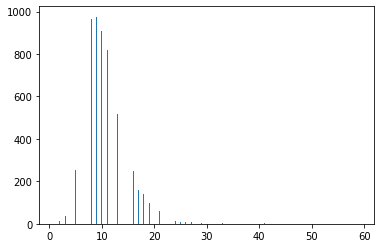

In [ ]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 20 words.
# Lets keep each news small and truncate all news to 20 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 20])

7970

In [ ]:
#Lets keep all news to 20, add padding to news with less than 20 words and truncating long ones
maxlen = 20 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
#all news has 20 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

20

In [ ]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [ ]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
print(embedding_vectors)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.77612978e-01  7.79598206e-03 -6.88280702e-01 ... -2.36688063e-01
  -2.34709844e-01  9.38635319e-03]
 [-3.98041010e-01 -5.09980647e-03 -6.70391798e-01 ... -2.23882765e-01
  -2.32518569e-01  3.81010287e-02]
 ...
 [-6.81792293e-03 -2.29077786e-03 -6.12452952e-03 ... -2.50740675e-03
  -4.54886147e-04  3.86878906e-04]
 [-3.54304095e-03  3.44530959e-03 -9.83652100e-03 ... -1.76029536e-03
  -6.56212308e-03  2.25547678e-03]
 [-3.89511511e-03 -3.05662607e-03 -2.68135383e-03 ...  1.70982454e-03
  -3.46021634e-03  9.46682179e-04]]


In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           1475500   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,592,877
Trainable params: 117,377
Non-trainable params: 1,475,500
_________________________________________________________________


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, target, test_size =0.20, random_state=4)

In [ ]:
len(x_train), len(x_test)

(6580, 1646)

In [ ]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
206/206 [==============================] - 2s 10ms/step - loss: 0.6778 - acc: 0.5685
Epoch 2/10
206/206 [==============================] - 2s 9ms/step - loss: 0.6738 - acc: 0.5701
Epoch 3/10
206/206 [==============================] - 2s 9ms/step - loss: 0.6742 - acc: 0.5767
Epoch 4/10
206/206 [==============================] - 2s 9ms/step - loss: 0.6716 - acc: 0.5845
Epoch 5/10
206/206 [==============================] - 2s 10ms/step - loss: 0.6673 - acc: 0.5860
Epoch 6/10
206/206 [==============================] - 2s 9ms/step - loss: 0.6675 - acc: 0.5886
Epoch 7/10
206/206 [==============================] - 2s 9ms/step - loss: 0.6645 - acc: 0.5900
Epoch 8/10
206/206 [==============================] - 2s 9ms/step - loss: 0.6637 - acc: 0.5939
Epoch 9/10
206/206 [==============================] - 2s 9ms/step - loss: 0.6621 - acc: 0.5979
Epoch 10/10
206/206 [==============================] - 2s 9ms/step - loss: 0.6599 - acc: 0.5950


In [ ]:
#Prediction is in probability of news being true, so converting into classes
# Class 1 (Fake) if predicted prob < 0.5, else class 0 (Real)
y_pred = (model.predict(x_test) >= 0.5).astype("int")

In [ ]:
accuracy_score(y_test, y_pred)

0.5729040097205347

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.52      0.56       862
           1       0.54      0.63      0.58       784

    accuracy                           0.57      1646
   macro avg       0.58      0.58      0.57      1646
weighted avg       0.58      0.57      0.57      1646

